## Train with rgb loss, and visualize how the loss is being calculated and the views rendered

In [1]:
import time

from collections import OrderedDict
from pathlib import Path

import torch
from lib.structures.field_list import collect

from lib import utils, logger, config, modeling, solver, data

import os
import sys
sys.path.append('/usr/src/app/spsg/torch')
from utils.raycast_rgbd.raycast_rgbd import RaycastRGBD

%load_ext autoreload
%autoreload 2

## Setup

In [2]:
config.merge_from_file('configs/front3d_train_3d.yaml')

model = modeling.PanopticReconstruction()
device = torch.device(config.MODEL.DEVICE)
model.to(device, non_blocking=True)

model.log_model_info()
model.fix_weights()

# Setup optimizer, scheduler, checkpointer
optimizer = torch.optim.Adam(model.parameters(), config.SOLVER.BASE_LR,
                                          betas=(config.SOLVER.BETA_1, config.SOLVER.BETA_2),
                                          weight_decay=config.SOLVER.WEIGHT_DECAY)
scheduler = solver.WarmupMultiStepLR(optimizer, config.SOLVER.STEPS, config.SOLVER.GAMMA,
                                                  warmup_factor=1,
                                                  warmup_iters=0,
                                                  warmup_method="linear")


-----------------------------------------
unet_output_channels 16
unet_fetures 16
=====================CREATING RAYCAST RGBD MODEL=====================
=====================CREATING RAYCAST RGBD MODEL=====================
=====================CREATING RAYCAST RGBD MODEL=====================
#params discriminator 173040


In [3]:
model_dict = model.state_dict()
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of Trainable Parameters: {}".format(pytorch_total_params))

output_path = Path('output')
checkpointer = utils.DetectronCheckpointer(model, optimizer, scheduler, output_path)

# Load the checkpoint
checkpoint_data = checkpointer.load()

checkpoint_arguments = {}
checkpoint_arguments["iteration"] = 0

if config.SOLVER.LOAD_SCHEDULER:
    checkpoint_arguments.update(checkpoint_data)

# TODO: move to checkpointer?
if config.MODEL.PRETRAIN2D:
    pretrain_2d = torch.load(config.MODEL.PRETRAIN2D)
    model.load_state_dict(pretrain_2d["model"])
    
# Dataloader
dataloader = data.setup_dataloader(config.DATASETS.TRAIN)

Number of Trainable Parameters: 10367125
Number of Trainable Parameters: 10367125


# Train

In [4]:
# Switch training mode
# self.model.switch_training()
print(len(dataloader))
model.switch_training()
iteration = 0
iteration_end = time.time()
torch.autograd.set_detect_anomaly(True)

for idx, (image_ids, targets) in enumerate(dataloader):
    assert targets is not None, "error during data loading"
    data_time = time.time() - iteration_end
    # Get input images
    images = collect(targets, "color")

    # Pass through model
    # try:
    losses, results = model(images, targets)
    # except Exception as e:
    #     print(e, "skipping", image_ids[0])
    #     del targets, images
    #     continue
    
    # Accumulate total loss
    total_loss: torch.Tensor = 0.0
    log_meters = OrderedDict()
    rgb_loss = 0.0
    for loss_group in losses.values():
        for loss_name, loss in loss_group.items():
            if(loss_name == "rgb"):
                # print("loss_name: {}, loss: {}".format(loss_name, loss))
                rgb_loss = loss
            if torch.is_tensor(loss) and not torch.isnan(loss) and not torch.isinf(loss):
                total_loss += loss
                log_meters[loss_name] = loss.item()

    # Loss backpropagation, optimizer & scheduler step
    optimizer.zero_grad()

    if torch.is_tensor(total_loss):
        total_loss.backward()
        optimizer.step()
        scheduler.step()
        log_meters["total"] = total_loss.item()
    else:
        log_meters["total"] = total_loss

    # Minkowski Engine recommendation
    torch.cuda.empty_cache()
    
    # Save checkpoint
    if iteration % config.SOLVER.CHECKPOINT_PERIOD == 0:
        checkpointer.save(f"model_{iteration:07d}", **checkpoint_arguments)
    
    last_training_stage = model.set_current_training_stage(iteration)
    
    # Save additional checkpoint after hierarchy level
    if last_training_stage is not None:
        checkpointer.save(f"model_{last_training_stage}_{iteration:07d}", **checkpoint_arguments)
        logger.info(f"Finish {last_training_stage} hierarchy level")
        
    print("\riteration: {}, total_loss: {}, rgb_loss:{}".format(iteration, total_loss, rgb_loss), end="")
    if iteration%10 == 0:
        print("\riteration: {}, total_loss: {}, rgb_loss:{}".format(iteration, total_loss, rgb_loss))
        
    iteration += 1
    iteration_end = time.time()

    
        
    # if idx>4:
        # break


6000


/usr/local/lib/python3.8/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/usr/src/app/panoptic-reconstruction/lib/modeling/projection/sparse_projection.py:195: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  padding_offsets = difference // 2
/usr/local/lib/python3.8/dist-packages/MinkowskiEngine-0.5.1-py3.8-linux-x86_64.egg/MinkowskiEngine/MinkowskiSparseTensor.py:512: UserWarning: __floordiv__ is deprecated, and its behavior w

iteration: 0, total_loss: 24.35670280456543, rgb_loss:0.0
iteration: 10, total_loss: 6.449753761291504, rgb_loss:0.0
iteration: 20, total_loss: 5.575597286224365, rgb_loss:0.00
iteration: 30, total_loss: 4.689831256866455, rgb_loss:0.0
iteration: 40, total_loss: 5.032413482666016, rgb_loss:0.00
iteration: 50, total_loss: 4.983930587768555, rgb_loss:0.0
iteration: 60, total_loss: 4.985793113708496, rgb_loss:0.00
iteration: 70, total_loss: 4.974649429321289, rgb_loss:0.0
iteration: 80, total_loss: 4.856233596801758, rgb_loss:0.0
iteration: 90, total_loss: 5.072544097900391, rgb_loss:0.0
iteration: 100, total_loss: 4.684957981109619, rgb_loss:0.0
iteration: 110, total_loss: 4.680630207061768, rgb_loss:0.00
iteration: 120, total_loss: 4.6601948738098145, rgb_loss:0.0
iteration: 130, total_loss: 6.468959808349609, rgb_loss:0.00
iteration: 140, total_loss: 4.957747459411621, rgb_loss:0.00
iteration: 150, total_loss: 4.238698482513428, rgb_loss:0.00
iteration: 160, total_loss: 5.0186624526977

/usr/src/app/panoptic-reconstruction/lib/modeling/frustum/frustum_completion.py:302: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  predicted_coordinates[:, 1:] = predicted_coordinates[:, 1:] // prediction.tensor_stride[0]
/usr/src/app/panoptic-reconstruction/lib/modeling/frustum/frustum_completion.py:329: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_

iteration: 510, total_loss: 60.56858825683594, rgb_loss:0.00
iteration: 520, total_loss: 112.0640869140625, rgb_loss:0.00
iteration: 530, total_loss: 42.08205032348633, rgb_loss:0.00
iteration: 540, total_loss: 61.28780746459961, rgb_loss:0.00
iteration: 550, total_loss: 60.69979476928711, rgb_loss:0.00
iteration: 560, total_loss: 36.03385925292969, rgb_loss:0.00
iteration: 570, total_loss: 47.66824722290039, rgb_loss:0.00
iteration: 580, total_loss: 18.7127685546875, rgb_loss:0.000
iteration: 590, total_loss: 42.197261810302734, rgb_loss:0.0
iteration: 600, total_loss: 37.007110595703125, rgb_loss:0.0
iteration: 610, total_loss: 60.608333587646484, rgb_loss:0.0
iteration: 620, total_loss: 24.665184020996094, rgb_loss:0.0
iteration: 630, total_loss: 23.1240291595459, rgb_loss:0.0.0
iteration: 640, total_loss: 23.028629302978516, rgb_loss:0.0
iteration: 650, total_loss: 40.559730529785156, rgb_loss:0.0
iteration: 660, total_loss: 23.432226181030273, rgb_loss:0.0
iteration: 670, total_lo

/usr/src/app/panoptic-reconstruction/lib/modeling/frustum/frustum_completion.py:412: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  predicted_coordinates[:, 1:] = predicted_coordinates[:, 1:] // prediction.tensor_stride[0]
/usr/src/app/panoptic-reconstruction/lib/modeling/frustum/frustum_completion.py:511: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_

iteration: 1760, total_loss: 327.1198425292969, rgb_loss:167.163589477539068
iteration: 1770, total_loss: 274.8318786621094, rgb_loss:138.003448486328128
iteration: 1780, total_loss: 255.90623474121094, rgb_loss:128.93679809570312
iteration: 1790, total_loss: 219.3441162109375, rgb_loss:115.494033813476568
iteration: 1800, total_loss: 201.55343627929688, rgb_loss:119.02911376953125
iteration: 1810, total_loss: 215.45394897460938, rgb_loss:113.56896209716797
iteration: 1820, total_loss: 212.83546447753906, rgb_loss:116.53539276123047
iteration: 1830, total_loss: 199.9647979736328, rgb_loss:112.729240417480474
iteration: 1840, total_loss: 198.20932006835938, rgb_loss:110.09317779541016
iteration: 1850, total_loss: 201.79730224609375, rgb_loss:113.62643432617188
iteration: 1860, total_loss: 182.4453887939453, rgb_loss:111.183044433593756
iteration: 1870, total_loss: 158.17245483398438, rgb_loss:114.78768920898438
iteration: 1880, total_loss: 179.5338897705078, rgb_loss:120.013427734375984

## Get geometry and color predictions (sparse)

In [5]:

# from .lib.modeling.frustum.rgb_loss import rgb_loss
# print(results.keys())
# print(results['frustum'].keys())
geometry_sparse_prediction = results['frustum']['geometry']
rgb_sparse_prediction = results['frustum']['rgb']
semantic_sparse_prediction = results['frustum']['semantic3d']

print("geometry_sparse shape: ", geometry_sparse_prediction.shape)
print("rgb_sparse shape: ", rgb_sparse_prediction.shape)
print("semantic_sparse shape: ", semantic_sparse_prediction.shape)


aux_views = targets[0].get_field("aux_views").unsqueeze(0)
cam_poses = targets[0].get_field("cam_poses").unsqueeze(0)
print("aux_views shape: ", aux_views.shape)
print("cam_poses shape: ", cam_poses.shape)


geometry_sparse shape:  torch.Size([101378, 1])
rgb_sparse shape:  torch.Size([101378, 3])
semantic_sparse shape:  torch.Size([101378, 13])
aux_views shape:  torch.Size([1, 3, 3, 240, 320])
cam_poses shape:  torch.Size([1, 3, 1, 4, 4])


=====================CREATING RAYCAST RGBD MODEL=====================
=====================CREATING RAYCAST RGBD MODEL=====================
=====================CREATING RAYCAST RGBD MODEL=====================
#params discriminator 173040


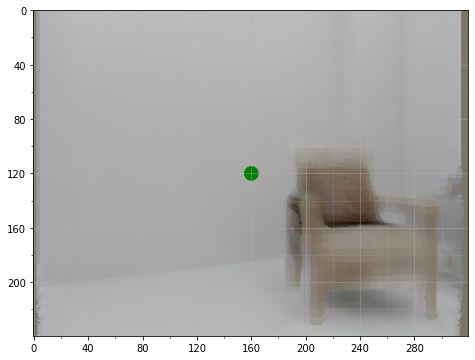

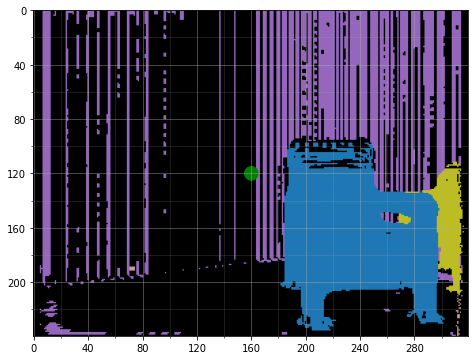

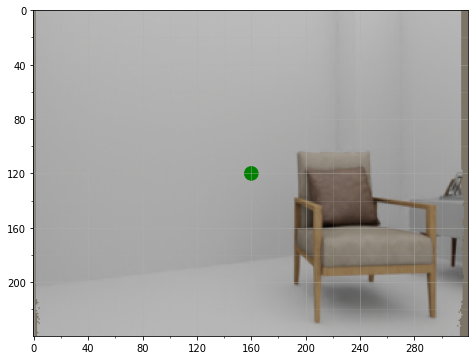

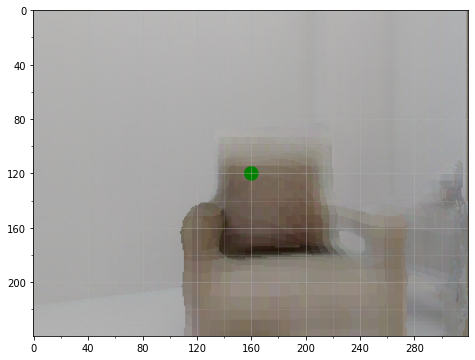

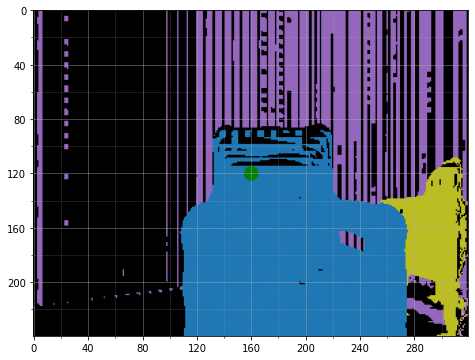

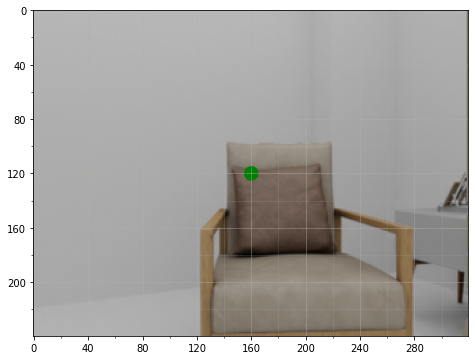

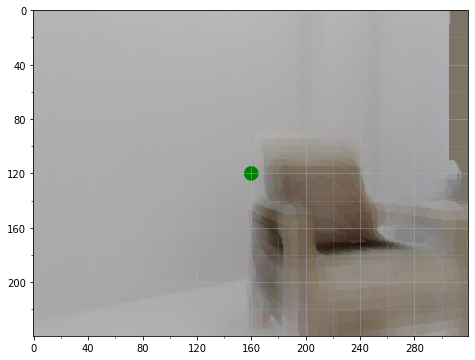

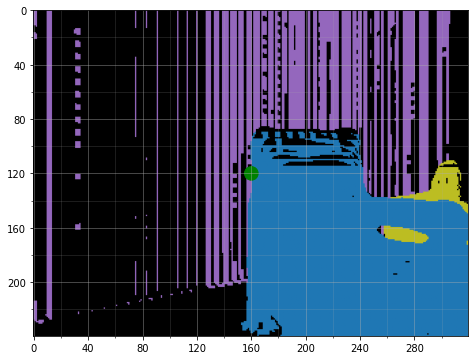

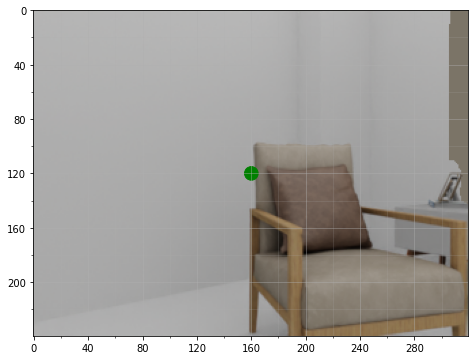

Total loss:  tensor(1.3810, device='cuda:0', grad_fn=<AddBackward0>)
L1 loss:  tensor(0.0336, device='cuda:0', grad_fn=<DivBackward0>)
style loss:  tensor(0.8681, device='cuda:0', grad_fn=<AddBackward0>)
loss_content:  tensor(203.2283, device='cuda:0', grad_fn=<AddBackward0>)
disc_loss:  tensor(1.4053, device='cuda:0', grad_fn=<AddBackward0>)
gen_loss:  tensor(0.6967, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


In [8]:
from lib.modeling.frustum.rgb_loss import RGBLoss
from plot_image_grid import plot_image
rgb_loss = RGBLoss()
loss = rgb_loss(geometry_sparse_prediction, rgb_sparse_prediction, semantic_sparse_prediction, aux_views, cam_poses.to(device), debug=True)

## Save Rendering

In [23]:
print(results['frustum'].keys())
# semantics_sparse = results['frustum']['semantic3d']
# geometry_sparse_prediction = results['frustum']['geometry']
# rgb_sparse_prediction = results['frustum']['rgb']
# semantic_sparse_prediction = results['frustum']['semantic3d']
# instance_result = results['instance']

dict_keys(['occupancy_64', 'instance3d_64', 'semantic3d_64', 'occupancy_128', 'instance3d_128', 'semantic3d_128', 'occupancy_256', 'geometry', 'instance3d', 'instance3d_prediction', 'semantic3d', 'semantic3d_label', 'rgb'])


In [33]:
from typing import List, Dict
import MinkowskiEngine as Me
from lib.modeling.utils import ModuleResult

def filter_instances(instances2d,  instances3d):
    instances_filtered = torch.zeros_like(instances3d)
    instance_ids_2d = (instances2d["locations"][0] + 1)
    for instance_id in instance_ids_2d:
        if instance_id != 0:
            instance_mask = instances3d == instance_id
            instances_filtered[instance_mask] = instance_id

    return instances_filtered

def nn_search(grid, point, radius=3):
    start = -radius
    end = radius
    label = torch.zeros([len(point)], device=point.device, dtype=grid.dtype)
    mask = torch.zeros_like(label).bool()

    for x in range(start, end):
        for y in range(start, end):
            for z in range(start, end):
                offset = torch.tensor([x, y, z], device=point.device)
                point_offset = point + offset
                label_bi = grid[point_offset[:, 0],
                                point_offset[:, 1],
                                point_offset[:, 2]]

                if label_bi.sum() != 0:
                    new_mask = (label_bi > 0) * (~mask)
                    label[new_mask] = label_bi[new_mask]
                    mask = mask + new_mask
    return label


def post_process(instance_data: Dict[str, torch.Tensor], frustum_data: Dict[str, Me.SparseTensor]) -> ModuleResult:
    print("==========Post Process==========")
    # dense
    device = frustum_data["instance3d"].device
    dense_dimensions = torch.Size([1, 1] + config.MODEL.FRUSTUM3D.GRID_DIMENSIONS)
    min_coordinates = torch.IntTensor([0, 0, 0]).to(device)
    truncation = config.MODEL.FRUSTUM3D.TRUNCATION
    iso_value = config.MODEL.FRUSTUM3D.ISO_VALUE

    geometry, _, _ = frustum_data["geometry"].dense(dense_dimensions, min_coordinates, default_value=truncation)
    instances, _, _ = frustum_data["instance3d"].dense(dense_dimensions, min_coordinates)
    semantics, _, _ = frustum_data["semantic3d_label"].dense(dense_dimensions, min_coordinates)
    rgb, _, _ = frustum_data["rgb"].dense(dense_dimensions, min_coordinates)

    print("geometry: {}".format(geometry.shape))
    print("instances: {}".format(instances.shape))
    print("semantics: {}".format(semantics.shape))
    print("rgb: {}".format(rgb.shape))

    geometry = geometry.squeeze()
    instances = instances.squeeze()
    semantics = semantics.squeeze()
    rgb = rgb.squeeze()


    # filter 3d instances by 2d instances
    instances_filtered = filter_instances(instance_data, instances)

    # merge output
    panoptic_instances = torch.zeros_like(geometry).int()
    panoptic_semantic_mapping = {}

    things_start_index = 2  # map wall and floor to id 1 and 2

    surface_mask = geometry.abs() <= 1.5

    # Merge things classes
    for index, instance_id in enumerate(instances_filtered.unique()):
        # Ignore freespace
        if instance_id != 0:
            # Compute 3d instance surface mask
            instance_mask: torch.Tensor = (instances == instance_id)

            if instance_mask.sum() > 0:
                # instance_surface_mask = instance_mask & surface_mask
                panoptic_instance_id = index + things_start_index
                panoptic_instances[instance_mask] = panoptic_instance_id

                # get semantic prediction
                semantic_region = torch.masked_select(semantics, instance_mask)
                semantic_things = semantic_region[(semantic_region != 0) & (semantic_region != 10) & (semantic_region != 11)]

                unique_labels, semantic_counts = torch.unique(semantic_things, return_counts=True)
                max_count, max_count_index = torch.max(semantic_counts, dim=0)
                selected_label = unique_labels[max_count_index]

                panoptic_semantic_mapping[panoptic_instance_id] = selected_label.int().item()


    # Merge stuff classes
    # Merge floor class
    wall_class = 10
    wall_id = 1
    wall_mask = semantics == wall_class
    panoptic_instances[wall_mask] = wall_id
    panoptic_semantic_mapping[wall_id] = wall_class

    # Merge floor class
    floor_class = 11
    floor_id = 2
    floor_mask = semantics == floor_class
    panoptic_instances[floor_mask] = floor_id
    panoptic_semantic_mapping[floor_id] = floor_class

    # Search label for unassigned surface voxels
    unassigned_voxels = (surface_mask & (panoptic_instances == 0).bool()).nonzero()

    panoptic_instances_copy = panoptic_instances.clone()
    # for voxel in unassigned_voxels:
    #     label = nn_search_old(panoptic_instances_copy, voxel)
    #
    #     panoptic_instances[voxel[0], voxel[1], voxel[2]] = label

    panoptic_instances[
            unassigned_voxels[:, 0],
            unassigned_voxels[:, 1],
            unassigned_voxels[:, 2]] = nn_search(panoptic_instances_copy, unassigned_voxels)

    panoptic_semantics = torch.zeros_like(panoptic_instances)

    for instance_id, semantic_label in panoptic_semantic_mapping.items():
        instance_mask = panoptic_instances == instance_id
        panoptic_semantics[instance_mask] = semantic_label
        
    print("rgb: {}".format(rgb.shape))
    result = {"panoptic_instances": panoptic_instances, "panoptic_semantics": panoptic_semantics,
                  "panoptic_semantic_mapping": panoptic_semantic_mapping, "rgb": rgb}

    return {}, result

In [39]:
# geometry_sparse_prediction = results['frustum']['geometry']
# rgb_sparse_prediction = results['frustum']['rgb']
# semantics_sparse = results['frustum']['semantic3d']
_,panoptic_result = post_process(results['instance'], results['frustum'])


==========Post Process==========
geometry: torch.Size([1, 1, 256, 256, 256])
instances: torch.Size([1, 1, 256, 256, 256])
semantics: torch.Size([1, 1, 256, 256, 256])
rgb: torch.Size([1, 3, 256, 256, 256])
rgb: torch.Size([3, 256, 256, 256])


In [35]:
from lib.structures import DepthMap
import numpy as np
from typing import Tuple
from lib.structures.frustum import compute_camera2frustum_transform
_imagenet_stats = {'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225]}

color_image_size = (320, 240)

dense_dimensions = torch.Size([1, 1] + config.MODEL.FRUSTUM3D.GRID_DIMENSIONS)
min_coordinates = torch.IntTensor([0, 0, 0]).to(device)
truncation = config.MODEL.FRUSTUM3D.TRUNCATION

# Get Dense Predictions
geometry, _, _ = geometry_sparse_prediction.dense(dense_dimensions, min_coordinates, default_value=truncation)
rgb, _, _ = rgb_sparse_prediction.dense(dense_dimensions, min_coordinates)
# semantics, _, _ = semantics_sparse.dense(dense_dimensions, min_coordinates)


geometry = geometry.squeeze()
rgb = rgb.squeeze()
print("input shape: ", images.shape)
print("rgb: {}".format(rgb.shape))
print("rgb values: [{},{}]".format(torch.max(rgb), torch.min(rgb)))
print("geometry: {}".format(geometry.shape))
print("geometry values: [{},{}]".format(torch.max(geometry), torch.min(geometry)))

input shape:  torch.Size([1, 3, 240, 320])
rgb: torch.Size([3, 256, 256, 256])
rgb values: [1.9303191900253296,-1.874485731124878]
geometry: torch.Size([256, 256, 256])
geometry values: [3.0,0.0]


In [36]:
def adjust_intrinsic(intrinsic: np.array, intrinsic_image_dim: Tuple, image_dim: Tuple) -> np.array:
    if intrinsic_image_dim == image_dim:
        return intrinsic

    intrinsic_return = np.copy(intrinsic)

    height_after = image_dim[1]
    height_before = intrinsic_image_dim[1]

    width_after = image_dim[0]
    width_before = intrinsic_image_dim[0]

    intrinsic_return[0, 0] *= float(width_after) / float(width_before)
    intrinsic_return[1, 1] *= float(height_after) / float(height_before)

    # account for cropping/padding here
    intrinsic_return[0, 2] *= float(width_after - 1) / float(width_before - 1)
    intrinsic_return[1, 2] *= float(height_after - 1) / float(height_before - 1)

    return intrinsic_return


# Generate Mesh and Render
# Prepare intrinsic matrix.
color_image_size = (320, 240)
depth_image_size = (160, 120)
front3d_intrinsic = np.array(config.MODEL.PROJECTION.INTRINSIC)
front3d_intrinsic = adjust_intrinsic(front3d_intrinsic, color_image_size, depth_image_size)
front3d_intrinsic = torch.from_numpy(front3d_intrinsic).to(device).float()

print('\n camera_instrinsics: \n', front3d_intrinsic)
camera2frustum = compute_camera2frustum_transform(front3d_intrinsic.cpu(), torch.tensor(images.size()) / 2.0,
                                                      config.MODEL.PROJECTION.DEPTH_MIN,
                                                      config.MODEL.PROJECTION.DEPTH_MAX,
                                                      config.MODEL.PROJECTION.VOXEL_SIZE)

camera2frustum[:3, 3] += (torch.tensor([256, 256, 256]) - torch.tensor([231, 174, 187])) / 2
frustum2camera = torch.inverse(camera2frustum)
print("frustum2camera: ", frustum2camera)


 camera_instrinsics: 
 tensor([[138.5641,   0.0000,  79.5000,   0.0000],
        [  0.0000, 138.5641,  59.5000,   0.0000],
        [  0.0000,   0.0000,   1.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   1.0000]], device='cuda:0')
frustum2camera:  tensor([[ 0.0300,  0.0000,  0.0000, -3.8175],
        [ 0.0000,  0.0300,  0.0000, -3.8064],
        [ 0.0000,  0.0000,  0.0300, -0.6350],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])


In [40]:
import lib.visualize as vis
vis.write_distance_field(geometry.squeeze(), panoptic_result['panoptic_semantics'].squeeze(), "out/mesh_semantics.ply", transform=frustum2camera)

In [15]:
from typing import Union, Tuple, Optional
import os
import marching_cubes as mc
from lib.utils.transform import coords_multiplication
from lib.visualize import io, utils

camera2frustum[:3, 3] += (torch.tensor([256, 256, 256]) - torch.tensor([231, 174, 187])) / 2
frustum2camera = torch.inverse(camera2frustum)

def write_distance_field2(distance_field: Union[np.array, torch.Tensor], labels: Optional[Union[np.array, torch.Tensor]],
                         output_file: os.PathLike, iso_value: float = 1.0, truncation: float = 3.0,
                         color_palette=None, transform=None) -> None:
    if isinstance(distance_field, torch.Tensor):
        distance_field = distance_field.detach().cpu().numpy()

    if isinstance(labels, torch.Tensor):
        labels = labels.detach().cpu().numpy()

    vertices, colors, triangles = get_mesh_with_colors2(distance_field, labels, iso_value, truncation,)

    if transform is not None:
        if isinstance(transform, torch.Tensor):
            transform = transform.detach().cpu().numpy()

        vertices = coords_multiplication(transform, vertices)

    io.write_ply(vertices, colors, triangles, output_file)




def get_mesh_with_colors2(distance_field: np.array, colors: np.array, iso_value: float = 1.0,
                         truncation: float = 3.0) -> Tuple[np.array, np.array, np.array]:
    print(distance_field.shape)
    print(colors.shape)
    
    vertices, triangles = mc.marching_cubes_color(distance_field, colors, iso_value, truncation)
    colors = vertices[..., 3:]
    colors = colors*_imagenet_stats['std']+_imagenet_stats['mean']
    print(colors.shape)
    print("colors range: [{},{}]".format(np.amin(colors), np.amax(colors)))
    colors *= 255.0
    vertices = vertices[..., :3]

    return vertices, colors, triangles

write_distance_field2(geometry, rgb.permute(1,2,3,0), "out/mesh_color2.ply", transform=frustum2camera)

(256, 256, 256)
(256, 256, 256, 3)
(43014, 3)
colors range: [0.00920987701416015,0.8608490583896637]


## Render using spsg
### Get Dense Predictions from Sparse Tensors

In [7]:
from lib.structures import DepthMap
import numpy as np
from typing import Tuple
from lib.structures.frustum import compute_camera2frustum_transform
import loss as loss_util

color_image_size = (320, 240)

dense_dimensions = torch.Size([1, 1] + config.MODEL.FRUSTUM3D.GRID_DIMENSIONS)
min_coordinates = torch.IntTensor([0, 0, 0]).to(device)
truncation = config.MODEL.FRUSTUM3D.TRUNCATION

# Get Dense Predictions
geometry, _, _ = geometry_sparse_prediction.dense(dense_dimensions, min_coordinates, default_value=truncation)
rgb, _, _ = rgb_sparse_prediction.dense(dense_dimensions, min_coordinates)
geometry = geometry.squeeze()
rgb = rgb.squeeze()
print("input shape: ", images.shape)
print("rgb: {}".format(rgb.shape))
print("rgb values: [{},{}]".format(torch.max(rgb), torch.min(rgb)))
print("geometry: {}".format(geometry.shape))
print("geometry values: [{},{}]".format(torch.max(geometry), torch.min(geometry)))

input shape:  torch.Size([1, 3, 240, 320])
rgb: torch.Size([3, 256, 256, 256])
rgb values: [3.0308997631073,-6.307973384857178]
geometry: torch.Size([256, 256, 256])
geometry values: [3.0,0.0]


## Get Tensors for raycaster

In [8]:
from pytorch3d.renderer import (
    look_at_view_transform,
)
from torch.nn import functional as F
def homogeneous_transform(R,t):
    last_row = torch.FloatTensor([[0,0,0,1]]).unsqueeze(0)
    T = torch.cat((R,t),dim=2)
    return torch.cat((T,last_row),dim=1)

sdf = geometry.clone()

# sdf*=2.0
# size = (256,128,256)
# rgb = (F.interpolate(rgb.unsqueeze(0), size=size, mode="trilinear", align_corners=True))[0]
# sdf = (F.interpolate(sdf.unsqueeze(0).unsqueeze(0), size=size, mode="trilinear", align_corners=True))[0,0]

truncation = 1.5
sdf = torch.clamp(sdf,0.0,3.0)
sdf-=1.5

print("colors shape: ", rgb.shape)
print("sdf shape: ", sdf.shape)



# # view_matrix = 

colors shape:  torch.Size([3, 256, 256, 256])
sdf shape:  torch.Size([256, 256, 256])


## Split in chunks

In [11]:
# sdf_chunks = []
# rgb_chunks = []
# for i in range(2):
#     sdf_chunks.append(sdf[:,i*128:(i+1)*128,:].unsqueeze(0))
#     rgb_chunks.append(rgb[:,:,i*128:(i+1)*128,:].unsqueeze(0))
    
# sdf_chunks = torch.cat(sdf_chunks).unsqueeze(1)
# rgb_chunks = torch.cat(rgb_chunks).unsqueeze(1)
# print("sdf_chunks shape: ", sdf_chunks.shape)
# print("rgb_chunks shape: ", rgb_chunks.shape)

sdf_chunks shape:  torch.Size([2, 1, 256, 128, 256])
rgb_chunks shape:  torch.Size([2, 1, 3, 256, 128, 256])


In [12]:
# vals_chunks = []
# colors_chunks = []
# locs_chunks = []
# for sdf, rgb in zip(sdf_chunks, rgb_chunks):
#     print("sdf shape: ", sdf.shape)
#     print("rgb shape: ", rgb.shape)
#     sdf = sdf.unsqueeze(0)

#     # colors = rgb.unsqueeze(0) #
#     rgb = rgb.permute(0,2,3,4,1)
#     # colors = rgb.permute(1,0,2,3).unsqueeze(0)

#     # colors = (F.interpolate(colors, size=(128,128,128), mode="nearest"))
#     print("sdf shape: ", sdf.shape)
#     print("colors shape: ", rgb.shape)
#     # print("colors2 shape: ", colors2.shape)


#     locs = torch.nonzero(torch.abs(sdf[:,0]) < truncation)
#     print("locs shape: ", locs.shape)

#     locs = torch.cat([locs[:,1:], locs[:,:1]],1).contiguous()
#     print("locs shape: ", locs.shape)
#     print("locs range [{},{}]: ".format(torch.min(locs), torch.max(locs)))

#     vals = sdf[locs[:,-1],:,locs[:,0],locs[:,1],locs[:,2]].contiguous()
#     colors = rgb[locs[:,-1],locs[:,0],locs[:,1],locs[:,2],:].float()
#     vals_chunks.append(vals)
#     colors_chunks.append(colors) #/255.0
#     locs_chunks.append(locs)


#     print("vals shape: ", vals.shape)
#     print("vals range: [{},{}]".format(torch.min(vals),torch.max(vals)))
#     print("colors shape: ", colors_chunks[0].shape)
#     print("colors range: [{},{}]".format(torch.min(colors),torch.max(colors)))

    


sdf shape:  torch.Size([1, 256, 128, 256])
rgb shape:  torch.Size([1, 3, 256, 128, 256])
sdf shape:  torch.Size([1, 1, 256, 128, 256])
colors shape:  torch.Size([1, 256, 128, 256, 3])
locs shape:  torch.Size([38059, 4])
locs shape:  torch.Size([38059, 4])
locs range [0,187]: 
vals shape:  torch.Size([38059, 1])
vals range: [-1.450927972793579,1.499509572982788]
colors shape:  torch.Size([38059, 3])
colors range: [-1.6043872833251953,1.2516789436340332]
sdf shape:  torch.Size([1, 256, 128, 256])
rgb shape:  torch.Size([1, 3, 256, 128, 256])
sdf shape:  torch.Size([1, 1, 256, 128, 256])
colors shape:  torch.Size([1, 256, 128, 256, 3])
locs shape:  torch.Size([64436, 4])
locs shape:  torch.Size([64436, 4])
locs range [0,187]: 
vals shape:  torch.Size([64436, 1])
vals range: [-1.4736192226409912,1.4999594688415527]
colors shape:  torch.Size([38059, 3])
colors range: [-1.6810451745986938,1.3721790313720703]


=====================CREATING RAYCAST RGBD MODEL=====================
2
raycast_color:  torch.Size([1, 240, 320, 3])
raycast_color1:  (240, 320, 3)
raycast_color1 range: [-1.5754448175430298,1.2063844203948975]
target_normals range: [-1.0,1.0]
raycast_color1 range: [0.0,1.2063844203948975]
(240, 320, 3)

raycast_normal_np range: [0,254]
(240, 320, 3)
raycast_color:  torch.Size([1, 240, 320, 3])
raycast_color1:  (240, 320, 3)
raycast_color1 range: [-1.6810451745986938,1.3065290451049805]
target_normals range: [-1.0,1.0]
raycast_color1 range: [0.0,1.3065290451049805]
(240, 320, 3)

raycast_normal_np range: [0,254]
(240, 320, 3)
img range: [-1.5754448175430298,1.2063844203948975]


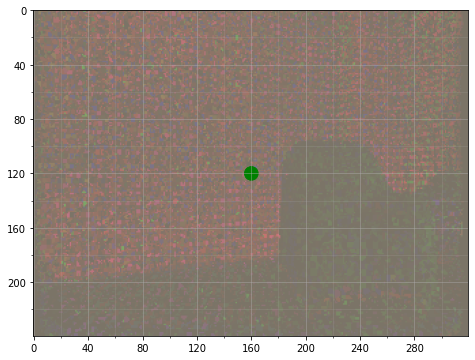

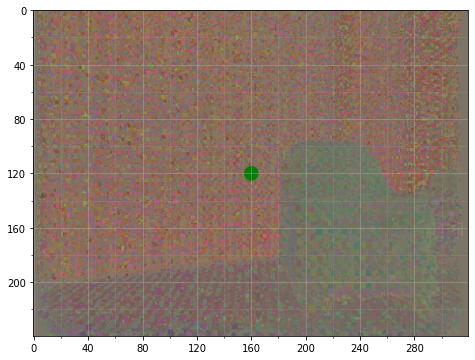

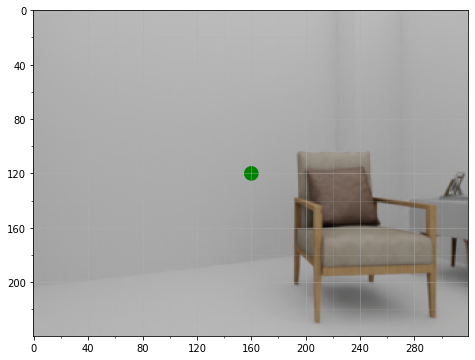

In [13]:
# import cv2
# import matplotlib.pyplot as plt
# from plot_image_grid import plot_image
# from utils.raycast_rgbd.raycast_rgbd import RaycastRGBD
# from PIL import Image

# # 14.399999999999999,30.700000000000024,-72.40000000000003
# size = (256,128,256)
# input_dim = (256,128,256)
# batch_size = 1
# style_width = 320
# style_height = 240
# voxelsize = 0.03
# raycast_depth_max = 6.0
# ray_increment = 0.03 * truncation
# thresh_sample_dist = 50.5 * ray_increment
# max_num_locs_per_sample = 640000
# intrinsics = torch.FloatTensor([[277.1281435, 311.76912635, 160.0, 120.0]]).to(device)
# _imagenet_stats = {'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225]}

# raycaster_rgbd = RaycastRGBD(batch_size, input_dim, style_width, style_height, depth_min=0.1/voxelsize, depth_max=raycast_depth_max/voxelsize, 
#                              thresh_sample_dist=thresh_sample_dist, ray_increment=ray_increment, max_num_locs_per_sample=max_num_locs_per_sample)
# _imagenet_stats = {'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225]}

# R0, t0 = look_at_view_transform(dist=-180, elev=0, azim=90)
# t0_list = torch.FloatTensor([[[20.0,127.5,127.5]],[[20.0,0.5,127.5]]])

# print(len(locs_chunks))
# results = []
# imgs = []
# for vals, colors, locs, sdf,t0 in zip(vals_chunks, colors_chunks, locs_chunks, sdf_chunks,t0_list):
#     sdf = sdf.unsqueeze(0)
#     view_matrix = homogeneous_transform(R0*1.0,t0.transpose(0,1).unsqueeze(0)).to(device)
#     vals = torch.randn_like(vals)
#     target_normals = loss_util.compute_normals_sparse(locs, vals, sdf.shape[2:], transform=torch.inverse(view_matrix))
#     raycast_color, _, raycast_normal = raycaster_rgbd(locs, vals, colors.contiguous(), target_normals, view_matrix, intrinsics)
#     raycast_color = torch.fliplr(raycast_color[0]).unsqueeze(0)
#     raycast_normal = torch.fliplr(raycast_normal[0]).unsqueeze(0)
#     mask = (torch.logical_or(torch.isinf(raycast_color),torch.isnan(raycast_color))).detach()
#     raycast_color[mask] = 0.0
#     imgs.append(raycast_color[0])
#     raycast_color_np = raycast_color[0].detach().cpu().numpy()
#     raycast_normal_np = raycast_normal[0].detach().cpu().numpy()
#     print("raycast_color: ",raycast_color.shape)

#     print("raycast_color1: ",raycast_color_np.shape)
#     print("raycast_color1 range: [{},{}]".format(np.amin(raycast_color_np), np.amax(raycast_color_np)))
#     print("target_normals range: [{},{}]".format(torch.min(target_normals), torch.max(target_normals)))
#     raycast_color_np[raycast_color_np<0.0] = 0.0
#     # raycast_color_np = (255.0*raycast_color_np).astype(np.uint8)
#     print("raycast_color1 range: [{},{}]".format(np.amin(raycast_color_np), np.amax(raycast_color_np)))
#     print(raycast_color_np.shape)
#     results.append(raycast_color_np)
#     # plot_image(raycast_color_np*_imagenet_stats['std']+_imagenet_stats['mean'])
#     raycast_normal_np[raycast_normal_np<0.0] = 0.0
#     raycast_normal_np = (255.0*raycast_normal_np).astype(np.uint8)
#     print("\nraycast_normal_np range: [{},{}]".format(np.amin(raycast_normal_np), np.amax(raycast_normal_np)))
#     print(raycast_normal_np.shape)
#     # plot_image(raycast_normal_np)

# img = imgs[0]+imgs[1]
# print("img range: [{},{}]".format(imgs[0].min(),imgs[0].max()))
# img = img.detach().cpu().numpy()
# result = results[0]+results[1]
# plot_image((result)*_imagenet_stats['std']+_imagenet_stats['mean'])
# plot_image((img)*_imagenet_stats['std']+_imagenet_stats['mean'])


# input_img = Image.open('data/front3d/70f7c6c1-c48f-4106-bcef-40b80b84bbad/rgb_0001.png')
# plot_image(input_img)

In [42]:

# sdf = sdf.unsqueeze(0).unsqueeze(0)

# # colors = rgb.unsqueeze(0) #
# colors = rgb.permute(1,2,3,0).unsqueeze(0)
# # colors = rgb.permute(1,0,2,3).unsqueeze(0)

# # colors = (F.interpolate(colors, size=(128,128,128), mode="nearest"))
# print("sdf shape: ", sdf.shape)
# print("colors shape: ", colors.shape)
# # print("colors2 shape: ", colors2.shape)


# locs = torch.nonzero(torch.abs(sdf[:,0]) < truncation)
# print("locs shape: ", locs.shape)

# locs = torch.cat([locs[:,1:], locs[:,:1]],1).contiguous()
# print("locs shape: ", locs.shape)
# print("locs range [{},{}]: ".format(torch.min(locs), torch.max(locs)))


# vals = sdf[locs[:,-1],:,locs[:,0],locs[:,1],locs[:,2]].contiguous()
# colors = colors[locs[:,-1],locs[:,0],locs[:,1],locs[:,2],:].float() #/255.0
# print("vals shape: ", vals.shape)
# print("vals range: [{},{}]".format(torch.min(vals),torch.max(vals)))
# print("colors shape: ", colors.shape)
# print("colors range: [{},{}]".format(torch.min(colors),torch.max(colors)))



sdf shape:  torch.Size([1, 1, 1, 1, 2, 1, 256, 256, 128])
colors shape:  torch.Size([1, 256, 256, 256, 3])
locs shape:  torch.Size([100616, 8])
locs shape:  torch.Size([100616, 8])
locs range [0,188]: 


RuntimeError: CUDA out of memory. Tried to allocate 3144.25 GiB (GPU 0; 14.76 GiB total capacity; 2.68 GiB already allocated; 7.71 GiB free; 5.43 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

# Project input image for test

In [10]:
# # Get color gt
# # input_img = results["input"]
# from lib.utils.intrinsics import adjust_intrinsic

# from PIL import Image
# import lib.data.transforms2d as t2d
# from lib.structures import DepthMap

# input_path = 'data/front3d/70f7c6c1-c48f-4106-bcef-40b80b84bbad/rgb_0001.png'
# input_image = Image.open(input_path)
# input_image_orig = input_image.copy()

# from torchvision import transforms
# image_transforms = t2d.Compose([
#     t2d.ToTensor(),
#     transforms.Scale((120,160))
# ])
# input_img = image_transforms(input_image_orig)
# input_img = input_img.view(3,-1)

# print("input_img: {}".format(input_img.shape))
# print("input_img range: [{},{}]".format(torch.min(input_img), torch.max(input_img)))
# color_pcl = input_img.permute(1, 0)
# print("color_pcl: {}".format(color_pcl.shape))

# depth_image_size = (160, 120)
# front3d_intrinsic = np.array(config.MODEL.PROJECTION.INTRINSIC)
# front3d_intrinsic = adjust_intrinsic(front3d_intrinsic, color_image_size, depth_image_size)
# front3d_intrinsic = torch.from_numpy(front3d_intrinsic).to(device).float()
# depth_map: DepthMap = DepthMap(results["depth"]['prediction'].squeeze(), front3d_intrinsic) 
# depth_map_pcl, depthmap_coords2d = depth_map.compute_pointcloud()
# print("depth_map_pcl: {}".format(depth_map_pcl.shape))
# depth_map_pcl[:,0]+=3.84
# depth_map_pcl[:,1]+=3.84
# depth_map_pcl[:,2]+=0.5


# locs2 = torch.nonzero(torch.abs(sdf) < truncation)
# locs2 = locs[:,:3].type(torch.FloatTensor)*0.03
# print("locs2 shape: ", locs2.shape)
# print("locs2 range [{},{}]: ".format(torch.min(locs2), torch.max(locs2)))

# sim = torch.cdist(locs2.cpu(), depth_map_pcl.cpu())
# print("sim: {}".format(sim.shape))
# idxs = torch.argmin(sim, 1, keepdim=False)
# del sim
# print("idxs: ", idxs.shape)
# print("idxs range [{},{}]: ".format(torch.min(idxs), torch.max(idxs)))

# colors_rgb = torch.zeros_like(locs2).cuda()
# print("colors_rgb shape: ", colors_rgb.shape)

# for i, idx in enumerate(idxs):
#     colors_rgb[i,:] = color_pcl[idx,:]
    
# print("colors_rgb: {}".format(colors_rgb.shape))
# print("colors_rgb range: [{},{}]".format(torch.min(colors_rgb), torch.max(colors_rgb)))

## Raycast to render views

In [38]:
# import cv2
# import matplotlib.pyplot as plt
# from plot_image_grid import plot_image
# from utils.raycast_rgbd.raycast_rgbd import RaycastRGBD
# from PIL import Image

# # 14.399999999999999,30.700000000000024,-72.40000000000003
# input_dim = (256,256,128)
# batch_size = 1
# style_width = 320
# style_height = 240
# voxelsize = 0.03
# raycast_depth_max = 6.0
# ray_increment = 0.03 * truncation
# thresh_sample_dist = 100.5 * ray_increment
# max_num_locs_per_sample = 640000
# intrinsics = torch.FloatTensor([[277.1281435, 311.76912635*2, 160.0, 120.0]]).to(device)

# raycaster_rgbd = RaycastRGBD(batch_size, input_dim, style_width, style_height, depth_min=0.1/voxelsize, depth_max=raycast_depth_max/voxelsize, 
#                              thresh_sample_dist=thresh_sample_dist, ray_increment=ray_increment, max_num_locs_per_sample=max_num_locs_per_sample)

# R0, t0 = look_at_view_transform(dist=-180, elev=0, azim=90)
# t0 = torch.FloatTensor([[0.0,127.5,127.5]])


# for vals, colors, locs, sdf in zip(vals_chunks, colors_chunks, locs_chunks, sdf_chunks):
#     print(sdf.shape)
#     sdf = sdf.unsqueeze(0)
#     view_matrix = homogeneous_transform(R0*1.0,t0.transpose(0,1).unsqueeze(0)).to(device)

#     target_normals = loss_util.compute_normals_sparse(locs, vals, sdf.shape[2:], transform=torch.inverse(view_matrix))
#     raycast_color, _, raycast_normal = raycaster_rgbd(locs, vals, colors.contiguous(), target_normals, view_matrix, intrinsics)
#     raycast_color = torch.fliplr(raycast_color[0]).unsqueeze(0)
#     raycast_normal = torch.fliplr(raycast_normal[0]).unsqueeze(0)

#     raycast_color_np = raycast_color[0].detach().cpu().numpy()
#     raycast_normal_np = raycast_normal[0].detach().cpu().numpy()
#     print("raycast_color: ",raycast_color.shape)

#     print("raycast_color1: ",raycast_color_np.shape)
#     print("raycast_color1 range: [{},{}]".format(np.amin(raycast_color_np), np.amax(raycast_color_np)))
#     print("target_normals range: [{},{}]".format(torch.min(target_normals), torch.max(target_normals)))
#     raycast_color_np[raycast_color_np<0.0] = 0.0
#     raycast_color_np = (255.0*raycast_color_np).astype(np.uint8)
#     print("raycast_color1 range: [{},{}]".format(np.amin(raycast_color_np), np.amax(raycast_color_np)))
#     print(raycast_color_np.shape)
#     plot_image(raycast_color_np)
#     raycast_normal_np[raycast_normal_np<0.0] = 0.0
#     raycast_normal_np = (255.0*raycast_normal_np).astype(np.uint8)
#     print("\nraycast_normal_np range: [{},{}]".format(np.amin(raycast_normal_np), np.amax(raycast_normal_np)))
#     print(raycast_normal_np.shape)
#     plot_image(raycast_normal_np)

# input_img = Image.open('data/front3d/70f7c6c1-c48f-4106-bcef-40b80b84bbad/rgb_0001.png')
# plot_image(input_img)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [45]:
# cam2world = np.load('data/front3d/70f7c6c1-c48f-4106-bcef-40b80b84bbad/campose_0005.npz')
# print("blender_location: ", cam2world['blender_location'])
# print("blender_matrix: ", cam2world['blender_matrix'])
# print("blender_rotation_euler: ", cam2world['blender_rotation_euler'])
# print("camera2world: ", cam2world['camera2world'])
# print("fov_x: ", cam2world['fov_x'])
# print("fov_y: ", cam2world['fov_y'])
# print("intrinsic: ", cam2world['intrinsic'])
# print("room_id: ", cam2world['room_id'])

blender_location:  [-2.7242341   3.11311078  0.75      ]
blender_matrix:  [[ 9.14251387e-01  2.54579550e-06 -4.05147165e-01 -2.72423410e+00]
 [-4.05147165e-01  5.73470106e-06 -9.14251387e-01  3.11311078e+00]
 [-4.09921475e-09  1.00000000e+00  6.27438067e-06  7.50000000e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
blender_rotation_euler:  [ 1.57079005e+00  4.09921519e-09 -4.17139828e-01]
camera2world:  [[ 9.14251387e-01 -2.54579550e-06  4.05147165e-01 -2.72423410e+00]
 [-4.05147165e-01 -5.73470106e-06  9.14251387e-01  3.11311078e+00]
 [-4.09921475e-09 -1.00000000e+00 -6.27438067e-06  7.50000000e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
fov_x:  1.0471975803375244
fov_y:  0.7348438501358032
intrinsic:  [[277.12811989   0.         160.        ]
 [  0.         311.76912635 120.        ]
 [  0.           0.           1.        ]]
room_id:  5


In [49]:
# # Base transform (Original transform to render images in the view frustum)
# R0, t0 = look_at_view_transform(dist=-180, elev=0, azim=90)
# t0 = torch.FloatTensor([[10.0,63.5,63.5]])
# voxelsize = 0.06
# T_C1W = homogeneous_transform(R0,t0.transpose(0,1).unsqueeze(0))
# print("\T_C1W: ", T_C1W)

# # Ground truth camera pose in the dataset
# cam2world = np.load('data/front3d/70f7c6c1-c48f-4106-bcef-40b80b84bbad/campose_0001.npz')['camera2world']
# print("cam2world", cam2world.shape)
# t1 = cam2world[:-1,-1]/voxelsize
# R1 = cam2world[:3,:3]
# t1 = torch.from_numpy(t1).type(torch.FloatTensor).unsqueeze(0)
# R1 = torch.from_numpy(R1).type(torch.FloatTensor).unsqueeze(0)
# T_GC1 = homogeneous_transform(R1,t1.transpose(0,1).unsqueeze(0))
# print("\nT_GC1: ", T_GC1)

# # Auxiliary views:
# # View 1
# cam2world = np.load('data/front3d/70f7c6c1-c48f-4106-bcef-40b80b84bbad/campose_0005.npz')['camera2world']
# t2 = cam2world[:-1,-1]/voxelsize
# R2 = cam2world[:3,:3]
# t2 = torch.from_numpy(t2).type(torch.FloatTensor).unsqueeze(0)
# R2 = torch.from_numpy(R2).type(torch.FloatTensor).unsqueeze(0)
# T_GC2 = homogeneous_transform(R2,t2.transpose(0,1).unsqueeze(0))
# print("\nT_GC2: ", T_GC2 )

# # Compute transform to auxiliary view
# T_C2W=torch.zeros_like(T_C1W) 
# T_C2W[0] = torch.inverse(T_GC2[0]) @ T_GC1[0] @ T_C1W
# print("T_C2W: ", T_C2W )

# # View 2
# cam2world = np.load('data/front3d/70f7c6c1-c48f-4106-bcef-40b80b84bbad/campose_0018.npz')['camera2world']
# t3 = cam2world[:-1,-1]/voxelsize
# R3 = cam2world[:3,:3]
# t3 = torch.from_numpy(t3).type(torch.FloatTensor).unsqueeze(0)
# R3 = torch.from_numpy(R3).type(torch.FloatTensor).unsqueeze(0)
# T_GC3 = homogeneous_transform(R3,t3.transpose(0,1).unsqueeze(0))
# print("\nT_GC3: ", T_GC3 )

# # Compute transform to auxiliary view
# T_C3W=torch.zeros_like(T_C1W) 
# T_C3W[0] = torch.inverse(T_GC3[0]) @ T_GC1[0] @ T_C1W
# print("T_C3W: ", T_C3W )

# # View 2
# cam2world = np.load('data/front3d/70f7c6c1-c48f-4106-bcef-40b80b84bbad/campose_0021.npz')['camera2world']
# t4 = cam2world[:-1,-1]/voxelsize
# R4 = cam2world[:3,:3]
# t4 = torch.from_numpy(t4).type(torch.FloatTensor).unsqueeze(0)
# R4 = torch.from_numpy(R4).type(torch.FloatTensor).unsqueeze(0)
# T_GC4 = homogeneous_transform(R4,t4.transpose(0,1).unsqueeze(0))
# print("\nT_GC4: ", T_GC4 )

# # Compute transform to auxiliary view
# T_C4W=torch.zeros_like(T_C1W) 
# T_C4W[0] = torch.inverse(T_GC4[0]) @ T_GC1[0] @ T_C1W
# print("T_C4W: ", T_C4W )

\T_C1W:  tensor([[[-4.3711e-08,  0.0000e+00,  1.0000e+00,  1.0000e+01],
         [ 0.0000e+00,  1.0000e+00,  0.0000e+00,  6.3500e+01],
         [-1.0000e+00,  0.0000e+00, -4.3711e-08,  6.3500e+01],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]]])
cam2world (4, 4)

T_GC1:  tensor([[[ 8.9057e-01, -2.8493e-06,  4.5484e-01, -5.9117e+01],
         [-4.5484e-01, -5.5901e-06,  8.9057e-01,  4.4425e+01],
         [ 5.1204e-09, -1.0000e+00, -6.2744e-06,  1.2500e+01],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]]])

T_GC2:  tensor([[[ 9.1425e-01, -2.5458e-06,  4.0515e-01, -4.5404e+01],
         [-4.0515e-01, -5.7347e-06,  9.1425e-01,  5.1885e+01],
         [-4.0992e-09, -1.0000e+00, -6.2744e-06,  1.2500e+01],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]]])
T_C2W:  tensor([[[-5.5023e-02, -3.3602e-07,  9.9849e-01,  3.9640e+00],
         [-9.2796e-09,  1.0000e+00,  3.3602e-07,  6.3500e+01],
         [-9.9849e-01,  9.2227e-09, -5.5023e-02,  5.0478e+01

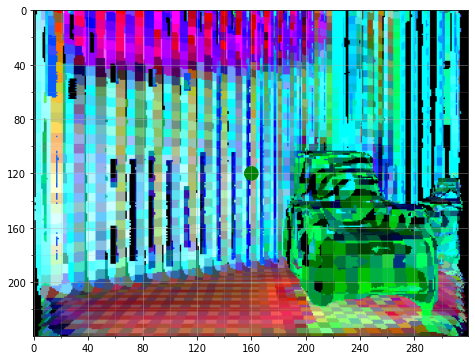

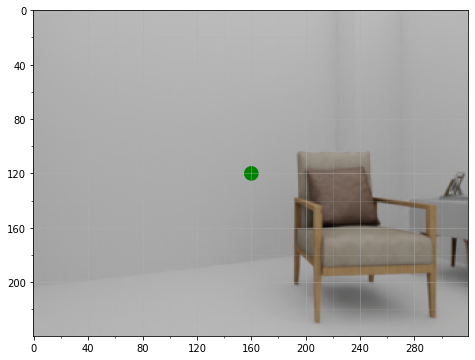

In [50]:
T_CW = T_C1W.clone()
view_matrix = homogeneous_transform(T_CW[:,:3,:3],T_CW[:,:3,-1].transpose(0,1).unsqueeze(0)).to(device)

target_normals = loss_util.compute_normals_sparse(locs, vals, sdf.shape[2:], transform=torch.inverse(view_matrix))
raycast_color, _, raycast_normal = raycaster_rgbd(locs, vals, colors.contiguous(), target_normals, view_matrix, intrinsics)
raycast_color = torch.fliplr(raycast_color[0]).unsqueeze(0)
raycast_normal = torch.fliplr(raycast_normal[0]).unsqueeze(0)

raycast_color_np = raycast_color[0].detach().cpu().numpy()
raycast_normal_np = raycast_normal[0].detach().cpu().numpy()

raycast_color_np[raycast_color_np<0.0] = 0.0
raycast_color_np = (255.0*raycast_color_np).astype(np.uint8)
plot_image(raycast_color_np)
raycast_normal_np[raycast_normal_np<0.0] = 0.0
raycast_normal_np = (255.0*raycast_normal_np).astype(np.uint8)
# print(raycast_normal_np.shape)
# plot_image(raycast_normal_np)

input_img = Image.open('data/front3d/70f7c6c1-c48f-4106-bcef-40b80b84bbad/rgb_0001.png')
plot_image(input_img)

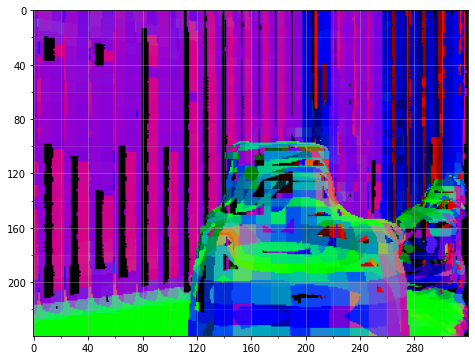

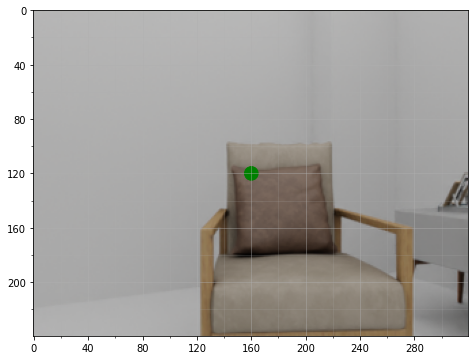

In [55]:
# T_CW = T_C2W.clone()
# offset = torch.FloatTensor([18.0,0.0,22.0])
# T_CW[:,:3,-1] += offset
# view_matrix = homogeneous_transform(T_CW[:,:3,:3],T_CW[:,:3,-1].transpose(0,1).unsqueeze(0)).to(device)

# target_normals = loss_util.compute_normals_sparse(locs, vals, sdf.shape[2:], transform=torch.inverse(view_matrix))
# raycast_color, _, raycast_normal = raycaster_rgbd(locs, vals, colors.contiguous(), target_normals, view_matrix, intrinsics)
# raycast_color = torch.fliplr(raycast_color[0]).unsqueeze(0)
# raycast_normal = torch.fliplr(raycast_normal[0]).unsqueeze(0)

# raycast_color_np = raycast_color[0].detach().cpu().numpy()
# raycast_normal_np = raycast_normal[0].detach().cpu().numpy()

# raycast_color_np[raycast_color_np<0.0] = 0.0
# raycast_color_np = (255.0*raycast_color_np).astype(np.uint8)
# # plot_image(raycast_color_np)
# raycast_normal_np[raycast_normal_np<0.0] = 0.0
# raycast_normal_np = (255.0*raycast_normal_np).astype(np.uint8)
# # print(raycast_normal_np.shape)
# plot_image(raycast_normal_np)

# input_img = Image.open('data/front3d/70f7c6c1-c48f-4106-bcef-40b80b84bbad/rgb_0005.png')
# plot_image(input_img)

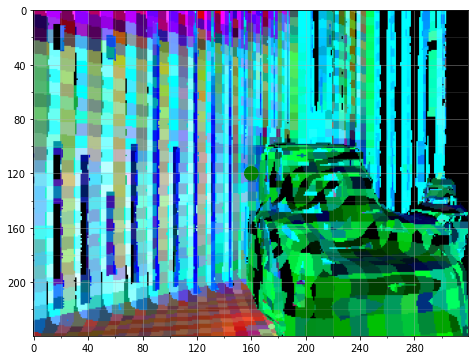

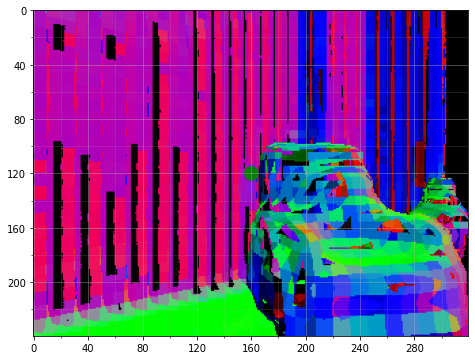

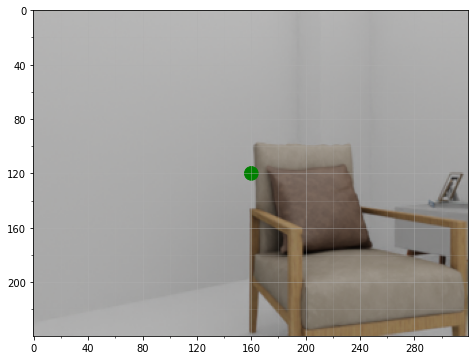

In [56]:
# from math import sin,cos
# def rot_y(t):
#     return torch.FloatTensor([[cos(t), 0, sin(t)],[0,1,0],[-sin(t),0,cos(t)]])

# T_CW = T_C3W.clone()
# offset = torch.FloatTensor([20.0,0.0,11.5])
# T_CW[:,:3,-1] += offset
# # T_CW[0,:3,:3] = rot_y(-0.0)@T_CW[0,:3,:3]
# view_matrix = homogeneous_transform(T_CW[:,:3,:3],T_CW[:,:3,-1].transpose(0,1).unsqueeze(0)).to(device)

# target_normals = loss_util.compute_normals_sparse(locs, vals, sdf.shape[2:], transform=torch.inverse(view_matrix))
# raycast_color, _, raycast_normal = raycaster_rgbd(locs, vals, colors.contiguous(), target_normals, view_matrix, intrinsics)
# raycast_color = torch.fliplr(raycast_color[0]).unsqueeze(0)
# raycast_normal = torch.fliplr(raycast_normal[0]).unsqueeze(0)

# raycast_color_np = raycast_color[0].detach().cpu().numpy()
# raycast_normal_np = raycast_normal[0].detach().cpu().numpy()

# raycast_color_np[raycast_color_np<0.0] = 0.0
# raycast_color_np = (255.0*raycast_color_np).astype(np.uint8)
# plot_image(raycast_color_np)
# raycast_normal_np[raycast_normal_np<0.0] = 0.0
# raycast_normal_np = (255.0*raycast_normal_np).astype(np.uint8)
# # print(raycast_normal_np.shape)
# plot_image(raycast_normal_np)

# input_img = Image.open('data/front3d/70f7c6c1-c48f-4106-bcef-40b80b84bbad/rgb_0018.png')
# plot_image(input_img)

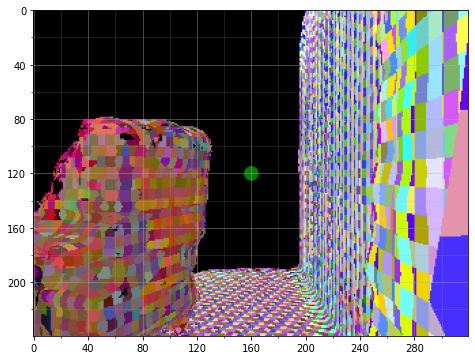

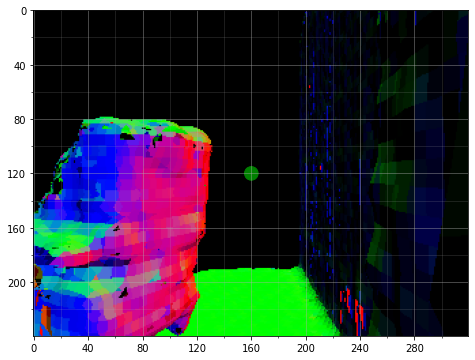

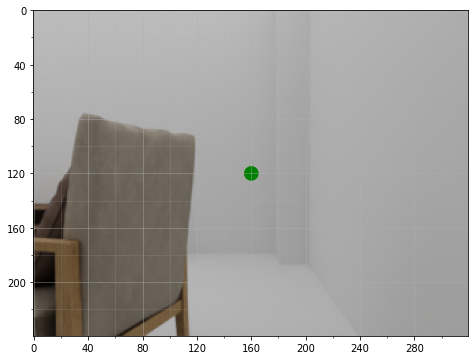

In [811]:
# T_CW = T_C4W.clone()
# offset = torch.FloatTensor([111.0,0.0,165.0])
# T_CW[:,:3,-1] += offset
# T_CW[0,:3,:3] = rot_y(-0.0)@T_CW[0,:3,:3]
# view_matrix = homogeneous_transform(T_CW[:,:3,:3],T_CW[:,:3,-1].transpose(0,1).unsqueeze(0)).to(device)

# target_normals = loss_util.compute_normals_sparse(locs, vals, sdf.shape[2:], transform=torch.inverse(view_matrix))
# raycast_color, _, raycast_normal = raycaster_rgbd(locs, vals, colors.contiguous(), target_normals, view_matrix, intrinsics)
# raycast_color = torch.fliplr(raycast_color[0]).unsqueeze(0)
# raycast_normal = torch.fliplr(raycast_normal[0]).unsqueeze(0)

# raycast_color_np = raycast_color[0].detach().cpu().numpy()
# raycast_normal_np = raycast_normal[0].detach().cpu().numpy()

# raycast_color_np[raycast_color_np<0.0] = 0.0
# raycast_color_np = (255.0*raycast_color_np).astype(np.uint8)
# plot_image(raycast_color_np)
# raycast_normal_np[raycast_normal_np<0.0] = 0.0
# raycast_normal_np = (255.0*raycast_normal_np).astype(np.uint8)
# # print(raycast_normal_np.shape)
# plot_image(raycast_normal_np)

# input_img = Image.open('data/front3d/70f7c6c1-c48f-4106-bcef-40b80b84bbad/rgb_0021.png')
# plot_image(input_img)

In [ ]:
# T_CW = T_C3W.clone()
# offset = torch.FloatTensor([33.0,0.0,25.0])
# # T_CW[:,:3,-1] += offset
# # T_CW[0,:3,:3] = rot_y(-0.2)@T_CW[0,:3,:3]
# view_matrix = homogeneous_transform(T_CW[:,:3,:3],T_CW[:,:3,-1].transpose(0,1).unsqueeze(0)).to(device)

# target_normals = loss_util.compute_normals_sparse(locs, vals, sdf.shape[2:], transform=torch.inverse(view_matrix))
# raycast_color, _, raycast_normal = raycaster_rgbd(locs, vals, colors.contiguous(), target_normals, view_matrix, intrinsics)
# raycast_color = torch.fliplr(raycast_color[0]).unsqueeze(0)
# raycast_normal = torch.fliplr(raycast_normal[0]).unsqueeze(0)

# raycast_color_np = raycast_color[0].detach().cpu().numpy()
# raycast_normal_np = raycast_normal[0].detach().cpu().numpy()

# raycast_color_np[raycast_color_np<0.0] = 0.0
# raycast_color_np = (255.0*raycast_color_np).astype(np.uint8)
# plot_image(raycast_color_np)
# raycast_normal_np[raycast_normal_np<0.0] = 0.0
# raycast_normal_np = (255.0*raycast_normal_np).astype(np.uint8)
# # print(raycast_normal_np.shape)
# plot_image(raycast_normal_np)

# input_img = Image.open('data/front3d/70f7c6c1-c48f-4106-bcef-40b80b84bbad/rgb_0021.png')
# plot_image(input_img)

## Perform one loss pass visualizing the predicted colored geometry from different views and how the loss is computed

# Save Rendering

In [9]:
from lib.structures import DepthMap
import numpy as np
from typing import Tuple
from lib.structures.frustum import compute_camera2frustum_transform

color_image_size = (320, 240)

dense_dimensions = torch.Size([1, 1] + config.MODEL.FRUSTUM3D.GRID_DIMENSIONS)
min_coordinates = torch.IntTensor([0, 0, 0]).to(device)
truncation = config.MODEL.FRUSTUM3D.TRUNCATION

# Get Dense Predictions
geometry, _, _ = geometry_sparse_prediction.dense(dense_dimensions, min_coordinates, default_value=truncation)
rgb, _, _ = rgb_sparse_prediction.dense(dense_dimensions, min_coordinates)
geometry = geometry.squeeze()
rgb = rgb.squeeze()
print("input shape: ", images.shape)
print("rgb: {}".format(rgb.shape))
print("rgb values: [{},{}]".format(torch.max(rgb), torch.min(rgb)))
print("geometry: {}".format(geometry.shape))
print("geometry values: [{},{}]".format(torch.max(geometry), torch.min(geometry)))

input shape:  torch.Size([1, 3, 240, 320])
rgb: torch.Size([3, 256, 256, 256])
rgb values: [1.0,0.0]
geometry: torch.Size([256, 256, 256])
geometry values: [3.0,0.0]


In [11]:
def adjust_intrinsic(intrinsic: np.array, intrinsic_image_dim: Tuple, image_dim: Tuple) -> np.array:
    if intrinsic_image_dim == image_dim:
        return intrinsic

    intrinsic_return = np.copy(intrinsic)

    height_after = image_dim[1]
    height_before = intrinsic_image_dim[1]

    width_after = image_dim[0]
    width_before = intrinsic_image_dim[0]

    intrinsic_return[0, 0] *= float(width_after) / float(width_before)
    intrinsic_return[1, 1] *= float(height_after) / float(height_before)

    # account for cropping/padding here
    intrinsic_return[0, 2] *= float(width_after - 1) / float(width_before - 1)
    intrinsic_return[1, 2] *= float(height_after - 1) / float(height_before - 1)

    return intrinsic_return


# Generate Mesh and Render
# Prepare intrinsic matrix.
color_image_size = (320, 240)
depth_image_size = (160, 120)
front3d_intrinsic = np.array(config.MODEL.PROJECTION.INTRINSIC)
front3d_intrinsic = adjust_intrinsic(front3d_intrinsic, color_image_size, depth_image_size)
front3d_intrinsic = torch.from_numpy(front3d_intrinsic).to(device).float()

print('\n camera_instrinsics: \n', front3d_intrinsic)
camera2frustum = compute_camera2frustum_transform(front3d_intrinsic.cpu(), torch.tensor(images.size()) / 2.0,
                                                      config.MODEL.PROJECTION.DEPTH_MIN,
                                                      config.MODEL.PROJECTION.DEPTH_MAX,
                                                      config.MODEL.PROJECTION.VOXEL_SIZE)

camera2frustum[:3, 3] += (torch.tensor([256, 256, 256]) - torch.tensor([231, 174, 187])) / 2
frustum2camera = torch.inverse(camera2frustum)
print("frustum2camera: ", frustum2camera)


 camera_instrinsics: 
 tensor([[138.5641,   0.0000,  79.5000,   0.0000],
        [  0.0000, 138.5641,  59.5000,   0.0000],
        [  0.0000,   0.0000,   1.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   1.0000]], device='cuda:0')
frustum2camera:  tensor([[ 0.0300,  0.0000,  0.0000, -3.8175],
        [ 0.0000,  0.0300,  0.0000, -3.8064],
        [ 0.0000,  0.0000,  0.0300, -0.6350],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])


In [37]:
from typing import Union, Tuple, Optional
import os
import marching_cubes as mc
from lib.utils.transform import coords_multiplication
from lib.visualize import io, utils

camera2frustum[:3, 3] += (torch.tensor([256, 256, 256]) - torch.tensor([231, 174, 187])) / 2
frustum2camera = torch.inverse(camera2frustum)

def write_distance_field2(distance_field: Union[np.array, torch.Tensor], labels: Optional[Union[np.array, torch.Tensor]],
                         output_file: os.PathLike, iso_value: float = 1.0, truncation: float = 3.0,
                         color_palette=None, transform=None) -> None:
    if isinstance(distance_field, torch.Tensor):
        distance_field = distance_field.detach().cpu().numpy()

    if isinstance(labels, torch.Tensor):
        labels = labels.detach().cpu().numpy()

    vertices, colors, triangles = get_mesh_with_colors2(distance_field, labels, iso_value, truncation,)

    if transform is not None:
        if isinstance(transform, torch.Tensor):
            transform = transform.detach().cpu().numpy()

        vertices = coords_multiplication(transform, vertices)

    io.write_ply(vertices, colors, triangles, output_file)




def get_mesh_with_colors2(distance_field: np.array, colors: np.array, iso_value: float = 1.0,
                         truncation: float = 3.0) -> Tuple[np.array, np.array, np.array]:
    print(distance_field.shape)
    print(colors.shape)
    
    vertices, triangles = mc.marching_cubes_color(distance_field, colors, iso_value, truncation)
    colors = vertices[..., 3:]
    vertices = vertices[..., :3]

    return vertices, colors, triangles

write_distance_field2(geometry, rgb.permute(1,2,3,0)*255, "out/mesh_color.ply", transform=frustum2camera)


In [39]:
write_distance_field2(geometry, rgb.permute(1,2,3,0)*255, "out/mesh_color.ply", transform=frustum2camera)

(256, 256, 256)
(256, 256, 256, 3)


In [10]:
surface_mask = geometry.squeeze() < 1.0
points_rgb = rgb[:,surface_mask].transpose(0,1)
points = surface_mask.squeeze().nonzero()

points = points.type(torch.FloatTensor)
points*=0.03
center = torch.FloatTensor([3.825+0.00,3.825-0.00,3.825-0.0])

points-=center
print(surface_mask.shape)
print(points_rgb.shape)
print(points.shape)
print("points values: [{},{}]".format(torch.max(points), torch.min(points)))

torch.Size([256, 256, 256])
torch.Size([35555, 3])
torch.Size([35555, 3])
points values: [1.7549998760223389,-1.5450000762939453]


In [651]:
# # Base transform (Original transform to render images in the view frustum)
# R0, t0 = look_at_view_transform(dist=-180, elev=0, azim=90)
# t0 = torch.FloatTensor([[20.0,128.0,128.0]])
# voxelsize = 0.03
# T_C1W = homogeneous_transform(R0,t0.transpose(0,1).unsqueeze(0))
# T_fix = torch.FloatTensor([[[1.0,0.0,0.0,20.0],[0.0,1.0,0.0,0.0],[0.0,0.0,1.0,0.0],[0.0,0.0,0.0,1.0]]])
# print("\T_C1W: ", T_C1W)
# # T_C1W[0] = T_fix@T_C1W[0] 
# print("\T_fix: ", T_C1W)

# permutations = [[0,1,2],[0,2,1],[1,0,2],[1,2,0],[2,0,1],[2,1,0]]
# signs = [[1,1,1],[-1,1,1],[-1,-1,1],[-1,-1,-1],[1,-1,1],[1,-1,-1],[1,1,-1],[-1,1,-1]]
# voxelsize = 0.03
# for p in permutations:
#     for sign in signs:
#         print(p)
#         print(sign)
#         # Ground truth camera pose in the dataset
#         cam2world = np.load('data/front3d/70f7c6c1-c48f-4106-bcef-40b80b84bbad/campose_0001.npz')['camera2world']
#         t1 = cam2world[:-1,-1]/voxelsize
#         t11 = t1.copy()
#         t1[0] = t11[p[0]]*sign[0]
#         t1[1] = t11[p[1]]*sign[1]
#         t1[2] = t11[p[2]]*sign[2]
#         R1 = cam2world[:3,:3]
#         t1 = torch.from_numpy(t1).type(torch.FloatTensor).unsqueeze(0)
#         R1 = torch.from_numpy(R1).type(torch.FloatTensor).unsqueeze(0)
#         T_GC1 = homogeneous_transform(R1,t1.transpose(0,1).unsqueeze(0))

#         # Auxiliary views:
#         # View 1
#         cam2world = np.load('data/front3d/70f7c6c1-c48f-4106-bcef-40b80b84bbad/campose_0005.npz')['camera2world']
#         t2 = cam2world[:-1,-1]/voxelsize
#         t21 = t2.copy()
#         t2[0] = t21[p[0]]*sign[0]
#         t2[1] = t21[p[1]]*sign[1]
#         t2[2] = t21[p[2]]*sign[2]
#         R2 = cam2world[:3,:3]
#         t2 = torch.from_numpy(t2).type(torch.FloatTensor).unsqueeze(0)
#         R2 = torch.from_numpy(R2).type(torch.FloatTensor).unsqueeze(0)
#         T_GC2 = homogeneous_transform(R2,t2.transpose(0,1).unsqueeze(0))

#         # Compute transform to auxiliary view
#         T_C2W=torch.zeros_like(T_C1W) 
#         T_C2W[0] = (T_GC2[0]) @ torch.inverse(T_GC1[0]) @ T_C1W


#         T_CW = T_C2W.clone()
#         # print(T_C2W)
#         # T_CW[:,0,-1] = T_C2W[:,0,-1] 
#         # T_CW[:,1,-1] = T_C2W[:,1,-1] 
#         # T_CW[:,2,-1] = T_C2W[:,2,-1] 

#         view_matrix = homogeneous_transform(T_CW[:,:3,:3],T_CW[:,:3,-1].transpose(0,1).unsqueeze(0)).to(device)

#         target_normals = loss_util.compute_normals_sparse(locs, vals, sdf.shape[2:], transform=torch.inverse(view_matrix))
#         raycast_color, _, raycast_normal = raycaster_rgbd(locs, vals, colors.contiguous(), target_normals, view_matrix, intrinsics)
#         raycast_color = torch.fliplr(raycast_color[0]).unsqueeze(0)
#         raycast_normal = torch.fliplr(raycast_normal[0]).unsqueeze(0)

#         raycast_color_np = raycast_color[0].detach().cpu().numpy()
#         raycast_normal_np = raycast_normal[0].detach().cpu().numpy()

#         raycast_color_np[raycast_color_np<0.0] = 0.0
#         raycast_color_np = (255.0*raycast_color_np).astype(np.uint8)
#         plot_image(raycast_color_np)

    
# # raycast_normal_np[raycast_normal_np<0.0] = 0.0
# # raycast_normal_np = (255.0*raycast_normal_np).astype(np.uint8)
# # print(raycast_normal_np.shape)
# # plot_image(raycast_normal_np)

# input_img = Image.open('data/front3d/70f7c6c1-c48f-4106-bcef-40b80b84bbad/rgb_0005.png')
# plot_image(input_img)

In [ ]:
# # Base transform (Original transform to render images in the view frustum)
# R0, t0 = look_at_view_transform(dist=-180, elev=0, azim=90)
# t0 = torch.FloatTensor([[20.0,128.0,128.0]])
# voxelsize = 0.04
# T_C1W = homogeneous_transform(R0,t0.transpose(0,1).unsqueeze(0))
# T_fix = torch.FloatTensor([[[1.0,0.0,0.0,20.0],[0.0,1.0,0.0,0.0],[0.0,0.0,1.0,0.0],[0.0,0.0,0.0,1.0]]])
# print("\T_C1W: ", T_C1W)
# # T_C1W[0] = T_fix@T_C1W[0] 
# print("\T_fix: ", T_C1W)


# # Ground truth camera pose in the dataset
# cam2world = np.load('data/front3d/70f7c6c1-c48f-4106-bcef-40b80b84bbad/campose_0001.npz')['camera2world']
# # cam2world = np.load('data/front3d/70f7c6c1-c48f-4106-bcef-40b80b84bbad/campose_0001.npz')['blender_matrix']
# print("cam2world", cam2world.shape)
# t1 = cam2world[:-1,-1]/voxelsize
# R1 = cam2world[:3,:3]
# t1 = torch.from_numpy(t1).type(torch.FloatTensor).unsqueeze(0)
# R1 = torch.from_numpy(R1).type(torch.FloatTensor).unsqueeze(0)
# T_GC1 = homogeneous_transform(R1,t1.transpose(0,1).unsqueeze(0))
# print("\nT_GC1: ", T_GC1)

# # Auxiliary views:
# # View 1
# cam2world = np.load('data/front3d/70f7c6c1-c48f-4106-bcef-40b80b84bbad/campose_0005.npz')['camera2world']
# t2 = cam2world[:-1,-1]/voxelsize

# R2 = cam2world[:3,:3]
# t2 = torch.from_numpy(t2).type(torch.FloatTensor).unsqueeze(0)
# R2 = torch.from_numpy(R2).type(torch.FloatTensor).unsqueeze(0)
# T_GC2 = homogeneous_transform(R2,t2.transpose(0,1).unsqueeze(0))
# print("\nT_GC2: ", T_GC2 )

# # Compute transform to auxiliary view
# T_C2W=torch.zeros_like(T_C1W) 
# T_C2W[0] = torch.inverse(T_GC2[0]) @ (T_GC1[0])
# print("T_C2W: ", T_C2W )
# T_C2W[0,:,-1]*=-1 # This helps
# # T_C2W[:,:3,:3] = torch.inverse(T_C2W[:,:3,:3])
# print("T_C2W: ", T_C2W )
# T_C2W =  T_C2W @ T_C1W
# # T_C2W[0,2,-1]  += -5


# # View 2
# cam2world = np.load('data/front3d/70f7c6c1-c48f-4106-bcef-40b80b84bbad/campose_0018.npz')['camera2world']
# t3 = cam2world[:-1,-1]/voxelsize
# R3 = cam2world[:3,:3]
# t3 = torch.from_numpy(t3).type(torch.FloatTensor).unsqueeze(0)
# R3 = torch.from_numpy(R3).type(torch.FloatTensor).unsqueeze(0)
# T_GC3 = homogeneous_transform(R3,t3.transpose(0,1).unsqueeze(0))
# print("\nT_GC3: ", T_GC3 )

# # Compute transform to auxiliary view
# T_C3W=torch.zeros_like(T_C1W) 
# T_C3W[0] = torch.inverse(T_GC3[0]) @ (T_GC1[0])
# print("T_C3W: ", T_C3W )
# T_C3W[0,:,-1]*=-1 # This helps
# # T_C2W[:,:3,:3] = torch.inverse(T_C2W[:,:3,:3])
# # print("T_C2W: ", T_C2W )
# T_C3W = T_C3W @ T_C1W
# # T_C3W[0,2,-1]  += -5


# T_CW = T_C2W.clone()
# print(T_C2W)

# view_matrix = homogeneous_transform(T_CW[:,:3,:3],T_CW[:,:3,-1].transpose(0,1).unsqueeze(0)).to(device)

# target_normals = loss_util.compute_normals_sparse(locs, vals, sdf.shape[2:], transform=torch.inverse(view_matrix))
# raycast_color, _, raycast_normal = raycaster_rgbd(locs, vals, colors.contiguous(), target_normals, view_matrix, intrinsics)
# raycast_color = torch.fliplr(raycast_color[0]).unsqueeze(0)
# raycast_normal = torch.fliplr(raycast_normal[0]).unsqueeze(0)

# raycast_color_np = raycast_color[0].detach().cpu().numpy()
# raycast_normal_np = raycast_normal[0].detach().cpu().numpy()

# raycast_color_np[raycast_color_np<0.0] = 0.0
# raycast_color_np = (255.0*raycast_color_np).astype(np.uint8)
# plot_image(raycast_color_np)
# raycast_normal_np[raycast_normal_np<0.0] = 0.0
# raycast_normal_np = (255.0*raycast_normal_np).astype(np.uint8)
# print(raycast_normal_np.shape)
# plot_image(raycast_normal_np)

# input_img = Image.open('data/front3d/70f7c6c1-c48f-4106-bcef-40b80b84bbad/rgb_0018.png')
# plot_image(input_img)

In [ ]:
# import k3d
# import numpy as np
# depth_map_pcl2 = locs2.clone()
# # depth_map_pcl2[:,0]+=3.84
# # depth_map_pcl2[:,1]+=3.84

# colors = np.random.randint(0xff,0xff0000,size=depth_map_pcl2.shape[0])
# plot = k3d.plot(camera_auto_fit=True)
# depth_map_pcl_np = depth_map_pcl2.detach().cpu().numpy()
# plt_points = k3d.points(depth_map_pcl_np, colors,point_size=0.05, shader="flat")
# plot += plt_points
# plot.display()